# Accumulator

The notebook considers the statistics of the accumulator. Previously, we've considered a synapse with Poisson input spikes, periodic input spikes, p-thinned period input spikes, and gamma-process input spikes. The gamma-process spikes are the closest approximation to date we have, but this notebook's purpose is to look directly at the accumulator.

The accumulator will not improve the snr of the input spike trains, but will output a cleaner signal than would otherwise have been output at the same given rates.

What about the dynamics of the accumulator? will it add an additional dynamical unit into our feedback loops?

$$
\dot{x} = u
$$

$$u=\sum_i\sum_j d_i\delta(t-t_{i,j})$$

$i$ is neuron index and $j$ is spike index

$$
x = \sum_i\sum_j d_iH(t-t_{i,j})
$$

I'd like to know when $x$ will reach threshold. It seems like that depends on the input spike rates and their respective decoding weights.

$$x=\sum_i\sum_jd_iH(t-jT_i-T_{i,0})$$

all of the input spikes are uniform but with random offsets $T_{i,0}$

That is, $T_{i,0}\sim U[0,T_i]$

# Accumulator structure and operation

The accumulator is 15 bits wide and uses the <a href="https://en.wikipedia.org/wiki/Ones%27_complement">one's complement</a> number representation. Each entry in the weight memory is 8 bits wide and also uses the one's complement number representation. In one's complement, the highest order bit indicates the sign while the lower order bits indicate the value. To convert between positive and negative numbers, flip all of the bits in the number. A 3-bit example is given as follows:

<table class="table-bordered">
<tr>
    <th colspan=9>3-bit one's complement example</th>
</tr>
<tr>
    <th>value</th> <th colspan=3>bit position</th> <th></th> <th>value</th> <th colspan=3>bit position</th>
</tr>
<tr>
    <th></th> <th>2</th> <th>1</th> <th>0</th> <th></th> <th></th> <th>2</th> <th>1</th> <th>0</th>
</tr>
<tr>
    <th>0</th> <td>0</td> <td>0</td> <td>0</td> <td></td> <th>-0</th> <td>1</td> <td>1</td> <td>1</td> 
</tr>
<tr>
    <th>1</th> <td>0</td> <td>0</td> <td>1</td> <td></td> <th>-1</th> <td>1</td> <td>1</td> <td>0</td> 
</tr>
<tr>
    <th>2</th> <td>0</td> <td>1</td> <td>0</td> <td></td> <th>-2</th> <td>1</td> <td>0</td> <td>1</td> 
</tr>
<tr>
    <th>3</th> <td>0</td> <td>1</td> <td>1</td> <td></td> <th>-3</th> <td>1</td> <td>0</td> <td>0</td> 
</tr>
</table>

For the given bit widths and the one's complement number system, the accumulator and each weight represent integers in the range [-16384:16384] and [-127:127], respectively.

When a neuron emits a spike, we lookup
* the neuron's decode weight from the weight memory
* the current decoded value from the accumulator memory
* the 3 threshold bits from the accumulator memory

We load the current decoded value into the accumulator and add the weight's value to the current decoded value. Since the weight has fewer bits than the current decoded value, we perform a sign extension to the weight before adding the two. Sign extension means adding extra higher order bits with the same value as the current highest order bit, which indicates the sign. Consider the following examples showing addition of 4 and 3 bit numbers.

<pre><code>
Example: 0+1=1

  0 0 0 0      0 in 4 bits
+   0 0 1    + 1 in 3 bits
---------    ---
  0 0 0 0      0
+ 0 0 0 1    + 1 now sign extended to 4 bits
---------    ---
  0 0 0 1      1 as we expect

Note how we padded the 3 bit number with a 0 because its sign bit was 0.
</code></pre>

<pre><code>
Example: 0-1=-1

  0 0 0 0       0  in 4 bits
+   1 1 0    +(-1) in 3 bits
---------    -----
  0 0 0 0       0
+ 1 1 1 0    +(-1) now sign extended to 4 bits
---------    -----
  1 1 1 0      -1  as we expect

Note how we padded the 3 bit number with a 1 because its sign bit was 1.
</code></pre>

<pre><code>
Example: -1+1=-0

  1 1 1 0     -1 in 4 bits
+   0 0 1    + 1 in 3 bits
---------    ---
  1 1 1 0     -1 
+ 0 0 0 1    + 1 now sign extended to 4 bits
---------    ---
  1 1 1 1     -0 as we expect

The negative sign on the 0 maybe disconcerting, but it will be fine in the one's complement system.
Consider the next example.
</code></pre>

<pre><code>
Example: -0+1=1

  1 1 1 1     -0 in 4 bits
+   0 0 1    + 1 in 3 bits
---------    ---
  1 1 1 1     -0 
+ 0 0 0 1    + 1 now sign extended to 4 bits
---------    ---
  0 0 0 0      0 Perform the addition. It generates a carry out of the highest order bit.
+       1    + 1 In one's complement, we add the generated carry bit to the lowest order bit.
---------    --- 
  0 0 0 1      1 as we expect
</code></pre>


After adding the current decoded value and the weight, we next consider the 3 threshold bits. The threshold bits indicate which of 8 bit positions in the accumulator are used for thresholding. As shown in the following table, any of bits 6-13 can be used as a threshold bit. Note that the threshold bits overlap with the bitwidth of the weight value, so we may configure a threshold and weight such that each spike in generates a spike out.

<table class="table table-bordered">
    <tr>
        <th colspan=15 style="text-align:center">
            accumulator bit position
        </th>
    </tr>
    <tr class="testrow">
        <td>14</td> <td>13</td> <td>12</td> <td>11</td> <td>10</td>
        <td>9</td> <td>8</td> <td>7</td> <td>6</td> <td>5</td>
        <td>4</td> <td>3</td> <td>2</td> <td>1</td> <td>0</td>
    </tr>
    <tr>
        <td colspan=8></td><th colspan=7 style="text-align:center">weight value</th>
    </tr>
    <tr>
        <td></td><th colspan=8 style="text-align:center">threshold bits</th><td colspan=6></td>
    </tr>
</table>

The weights are best thought of in units of the threshold.

PUT TABLE HERE

Raising the threshold bit position increases the precision of the weight at the cost of the dynamic range.  Draw a picture.

When threshold position bit position is at its lowest position

# Setting threshold

* pick an $f_{max}$
* represent $x=c\times f_{max}$ so that $x$ in $[-1:1]$ maps to firing rates in $[-f_{max}:f_{max}]$

The chip does not communicate in terms of real numbers, but rather spikes. We'll need to map the low-dimensional quantity $x$ to some spike rate $f$. Spikes can be signed. Something like

$$
f=f_{max}x
$$

so that for $x$ ranging in $[-1:1]$ (typical in nengo) we get an $f_{max}$ ranging in $[-f_{max}:f_{max}]$.

Each spike in to the accumulator will be weighted and added to the running sum. Assuming that the accumulator is always driven towards the positive or negative threshold, the value accumulated over a certain period of time will be given by

$$
\frac{\textrm{spikes_in}}{\textrm{s}}\cdot\frac{\textrm{weight}}{\textrm{spike_in}}\cdot \textrm{time} = \textrm{value accumulated}
$$

We can then apply the threshold to find the number of threshold crossings, or output spikes.

$$
\frac{\textrm{value accumulated}}{\textrm{threshold}}=\textrm{# threshold crossings}=\textrm{spikes out}
$$

To find the output rate, we divide the number of spikes out by the time

$$
\frac{\textrm{spikes out}}{\textrm{time}}=\frac{\textrm{spikes_in}}{\textrm{s}}\cdot\frac{\textrm{weight}}{\textrm{spike_in}}\cdot\frac{1}{\textrm{threshold}}
$$

for $N$ neurons spiking at rates $a_n$ with weights $d_n$ and accumulator with threshold $k$, we can formalize the previous discussion in the following equation

$$
\frac{\sum_{n=1}^Na_nd_n}{k} = f_{out}
$$

which implies that

$$
\sum_{n=1}^Na_nd_n = f_{out}k
$$

That is, we should set our decode weights and accumulator threshold appropriately by the above relationship. 

In this notebook, we'll go for a target spike rate of 1000.

In [1]:
%matplotlib inline
from acc import Pool, SpikeTrain
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import nengo
from nengo.utils.ensemble import tuning_curves
from nengo.utils.matplotlib import rasterplot as nengo_raster
np.set_printoptions(formatter={'float': '{: 0.8f}'.format})

# from IPython.core.display import HTML
# HTML(open("./styles/custom.css", "r").read())

In [2]:
def rasterplot(spike_trains, ax=None):
    """Wrap nengo rasterplot for this notebook
    Inputs
    ------
    spike_trains: SpikeTrain or list of spike_trains
    
    Outputs
    -------
    handle of axis used to plot
    """
    if type(spike_trains) is not list:
        spike_trains = [spike_trains]
    N = len(spike_trains)
    T = []
    for n in range(N):
        T.append(len(spike_trains[n].times))
    spikes = np.zeros((np.sum(T), N+1))
    
    idx0 = 0
    for n in range(N):
        idx1 = idx0 + T[n]
        spikes[idx0:idx1, 0] = spike_trains[n].times
        spikes[idx0:idx1, n+1] = 1
        idx0 = idx1
    
    time = spikes[:,0]
    spikes = spikes[:,1:]
    
    return nengo_raster(time, spikes, ax=ax)

In [3]:
def run_experiment(N, input_rates, weights, thresheld, T=1.):
    pool = Pool(N=N, spike_rates=input_rates, weights=weights, threshold=threshold)
    spks_in = pool.gen_nrn_spikes(T=T)
    merged_spks_in = pool.merge_spikes(spks_in)
    spks_out, acc_state = pool.gen_acc_spikes(merged_spks_in)
    return spks_in, acc_state, spks_out

def plot_timeseries(spks_in, acc_state, spks_out, tmin=None, tmax=None):
    fig, axs = plt.subplots(nrows=3, figsize=(12,9), sharex=True)
    rasterplot(spks_in, axs[0])
    axs[1].plot(acc_state.time, acc_state.state)
    axs[1].axhline(threshold, color='r')
    axs[1].axhline(-threshold, color='r')
    rasterplot(spks_out, axs[2])
    # set xlims
    axs[2].set_xlim([0, axs[2].get_xlim()[1]])
    if tmin:
        axs[2].set_xlim([tmin, axs[2].get_xlim()[1]])
    if tmax:
        axs[2].set_xlim([axs[2].get_xlim()[0], tmax])
    axs[2].set_xlabel('Time')
    axs[0].set_title('Accumulator Input Spikes')
    axs[1].set_title('Accumulator State')
    axs[2].set_title('Accumulator Output Spikes')

def plot_isi(spks, bins=50):
    """Plots histograms of the interspike intervals
    
    Creates histogram of all spikes
    and histograms of 
    Separates spikes into +1 and -1 spikes if applicable
    """
    spks.times = np.array(spks.times)
    spks.weights = np.array(spks.weights)
    out_isi = np.diff(spks.times)
    fig, ax = plt.subplots(nrows=1, figsize=(8,3), sharex=True)
    n, bins, patches = ax.hist(out_isi, bins)
    ax.set_title('Output ISI Histogram')
    ax.set_xlabel('Time')
    ax.set_ylabel('Counts')
    if(len(np.unique(spks.weights)) == 2):
        fig, axs = plt.subplots(nrows=2, figsize=(8,6), sharex=True)        

        out_isi = np.diff(spks.times[spks.weights == 1])
        n, bins, patches = axs[0].hist(out_isi, bins)
        axs[0].set_title('+1 Weighted Output ISI Histogram')
        axs[0].set_xlabel('Time')
        axs[0].set_ylabel('Counts')
        
        out_isi = np.diff(spks.times[spks.weights == -1])
        n, bins, patches = axs[1].hist(out_isi, bins)
        axs[1].set_title('-1 Weighted Output ISI Histogram')
        axs[1].set_xlabel('Time')
        axs[1].set_ylabel('Counts')

parameters to vary:
* number of neurons: 1,2,50,100,200
* weight distributions all: pos, mixed
* input neuron process: regular spiking, poisson spiking 

# Single neuron

Let's test the accumulator with a single neuron. The accumulator can only decimate the incoming spikes, so we won't be able to reach 1000.

First we consider when the neuron's weight is a multiple of the threshold

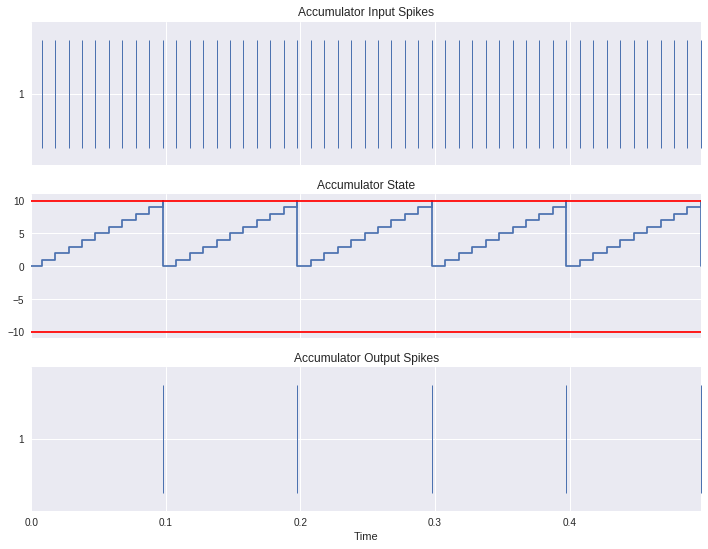

In [4]:
N = 1
input_rates = 100
weights = 1
threshold = 10
spks_in, acc_state, spks_out = run_experiment(
    N=N, input_rates=input_rates, weights=weights, thresheld=threshold, T=0.5)
plot_timeseries(spks_in, acc_state, spks_out)

As we expect, all of the output inter-spike intervals are the same. The accumulator simply decimates the traffic by the weight. A synapse receiving input from an accumulator would have the same statistics as one receiving input from a regularly spiking neuron of the same rate.

Don't take it for granted that the accumulator will improve signal quality. or will it?
try building an equivalent output rate from the same number of regular spiking input neurons.

Next we show that an accumulator can degrade the signal quality even when controlling rate. When the neuron's weight is not a divisor of the threshold, there is variation in the output ISI.

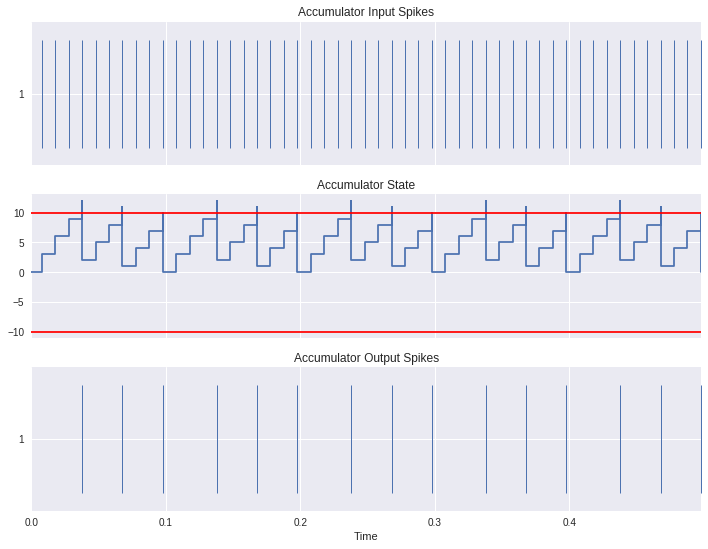

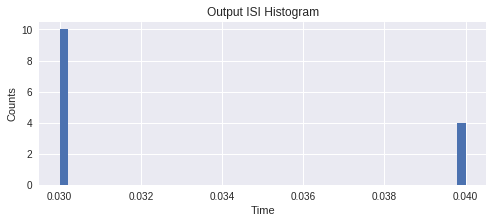

In [83]:
N = 1
input_rates = 100
weights = 3
threshold = 10
spks_in, acc_state, spks_out = run_experiment(
    N=N, input_rates=input_rates, weights=weights, thresheld=threshold, T=0.5)
plot_timeseries(spks_in, acc_state, spks_out)
plot_isi(spks_out, bins=50)

In this case, the output ISI will be variable

# Many Neurons, Regular Spiking, Random Weights

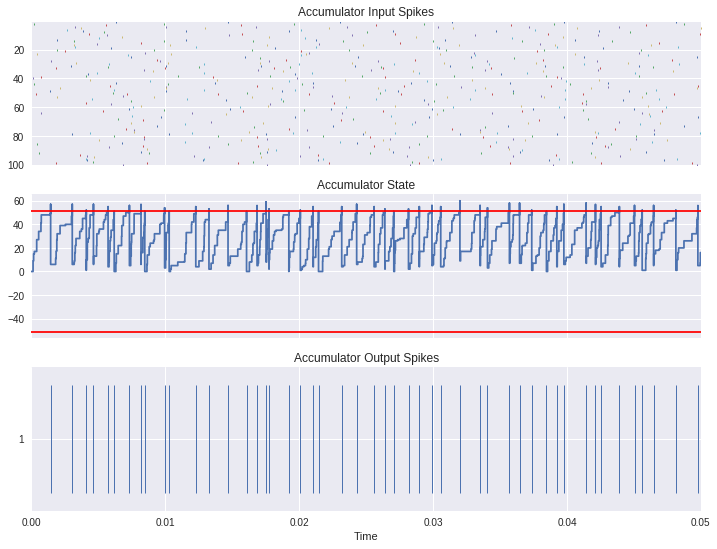

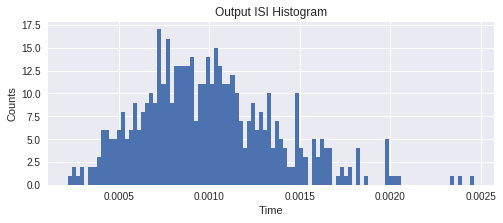

In [6]:
N = 100
input_rates = np.random.uniform(50, 150, size=N)
weights = np.random.randint(0, 11, size=N)
threshold = int(np.sum(input_rates*weights)/1000.)
T=10
spks_in, acc_state, spks_out = run_experiment(
    N=N, input_rates=input_rates, weights=weights, thresheld=threshold, T=0.5)
plot_timeseries(spks_in, acc_state, spks_out, tmax=0.05)
plot_isi(spks_out, bins=100)

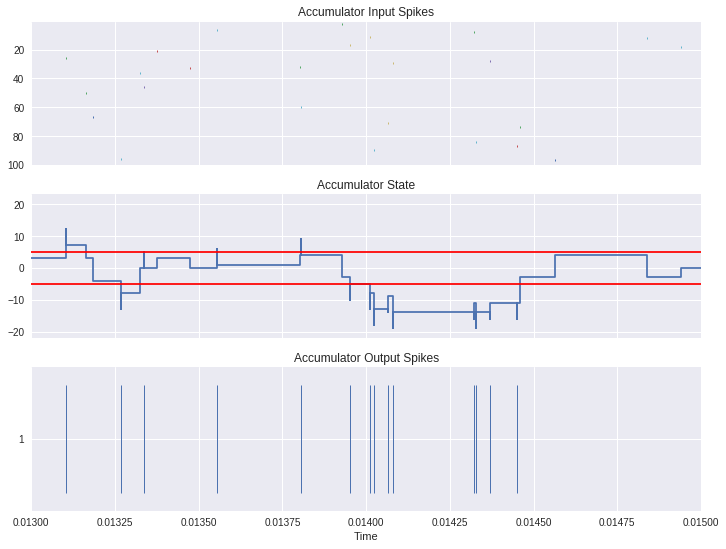

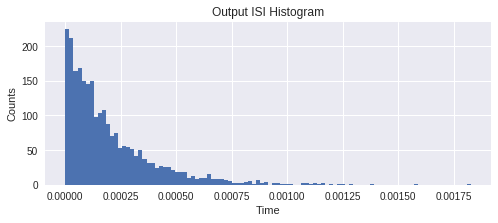

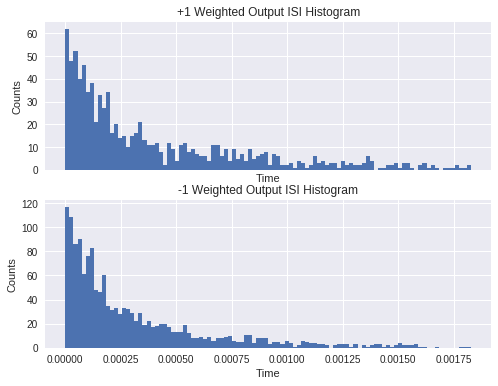

In [105]:
N = 100
np.random.seed(0)
input_rates = np.random.uniform(0, 200, size=N)
weights = np.random.randint(-10, 10, size=N)
threshold = int(np.abs(np.sum(input_rates*weights))/1000.)
T=10
spks_in, acc_state, spks_out = run_experiment(
    N=N, input_rates=input_rates, weights=weights, thresheld=threshold, T=0.5)
plot_timeseries(spks_in, acc_state, spks_out, tmin=0.013, tmax=0.015)
plot_isi(spks_out, bins=100)

# Nengo

In [4]:
def threshold_weights(weights):
    """compute the threshold and rounded weights from a given weight distribution
    """
    acc_wmax = np.array([1.] + [127./2**i for i in range(7, 14)])
    acc_unit = np.array([1./64] + [1./2**i for i in range(7, 14)])
    thresholds = np.array([2**i for i in range(6,14)])

    w_max = np.max(np.abs(weights))
    idx = np.argmax(w_max >= acc_wmax)-1
    w_rounded = np.rint(weights/acc_unit[idx]).astype(int)
    threshold = thresholds[idx]   
    return threshold, w_rounded


In [5]:
# build a network
N = 64
net = nengo.Network()
with net:
    stim = nengo.Node(lambda t: np.sin(2*np.pi*t), size_in=0, size_out=1)
    ens = nengo.Ensemble(N, 1)
    node = nengo.Node(lambda t, x: x, size_in=1, size_out=1)
    probe_in = nengo.Probe(stim)
    probe_out = nengo.Probe(node)
    nengo.Connection(stim, ens, synapse=0)
    conn = nengo.Connection(ens, node, function=lambda x: x, transform=1000)

sim = nengo.Simulator(net)

Building finished in 0:00:01.                                                   


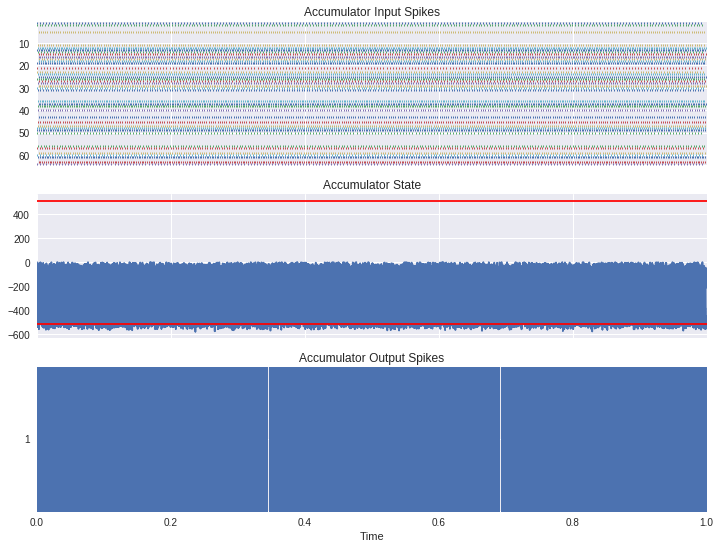

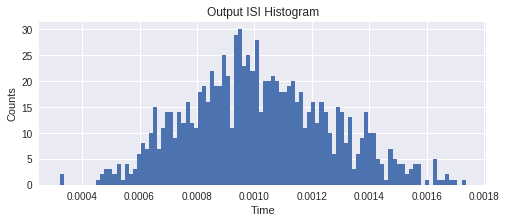

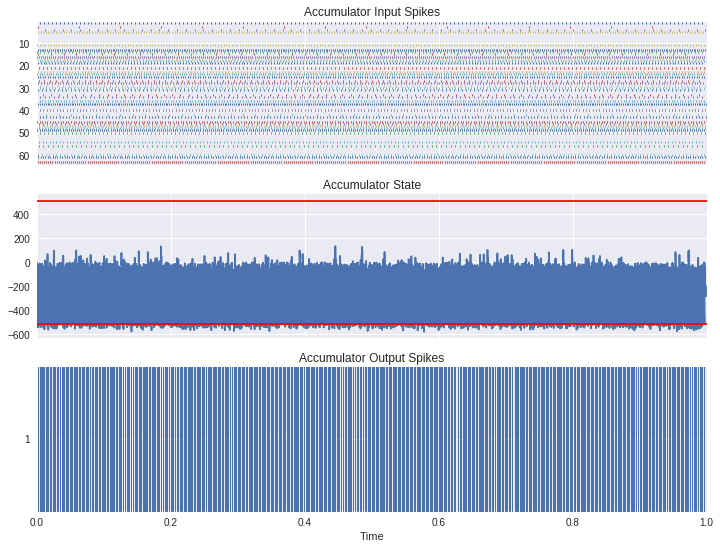

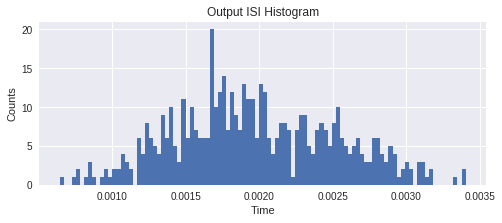

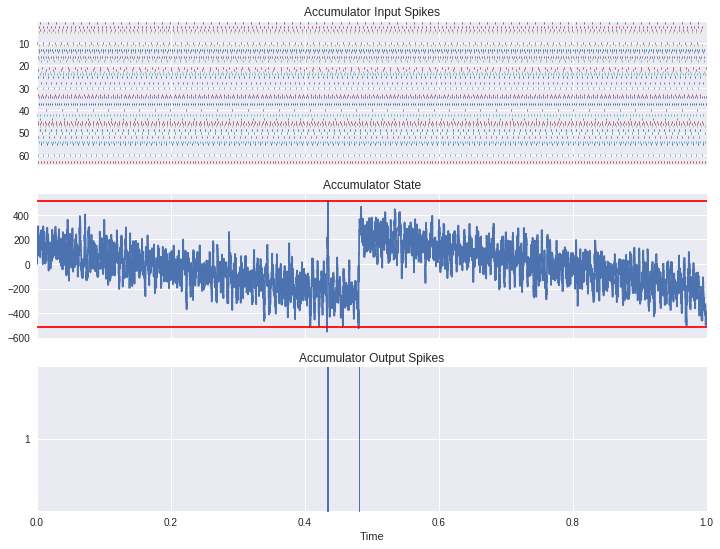

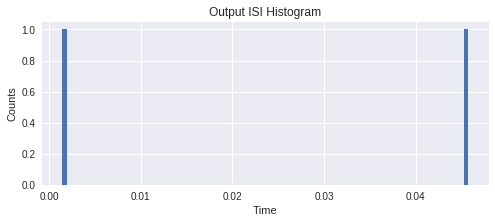

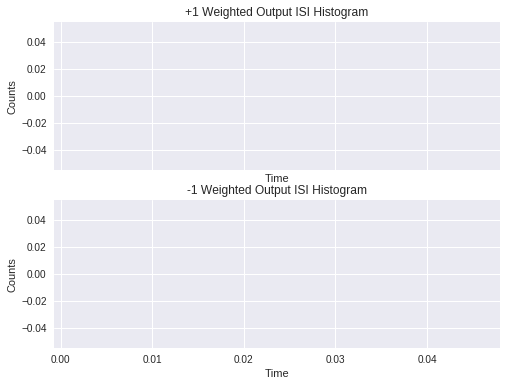

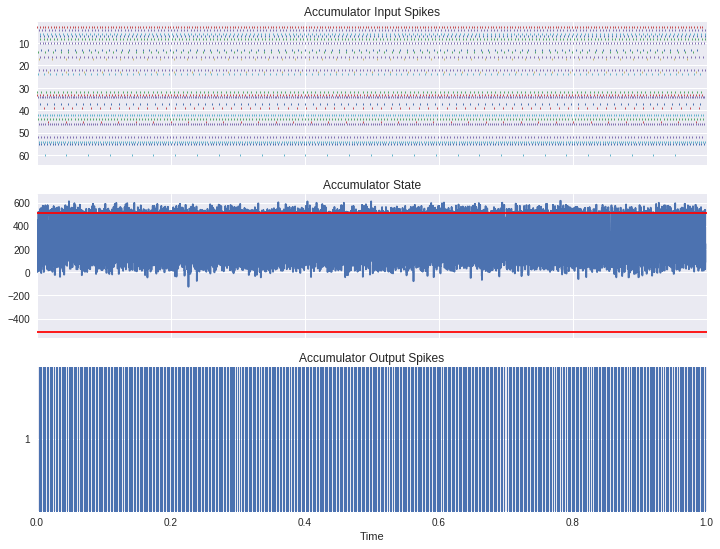

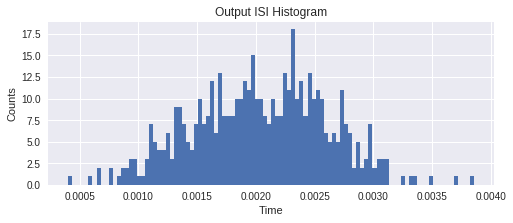

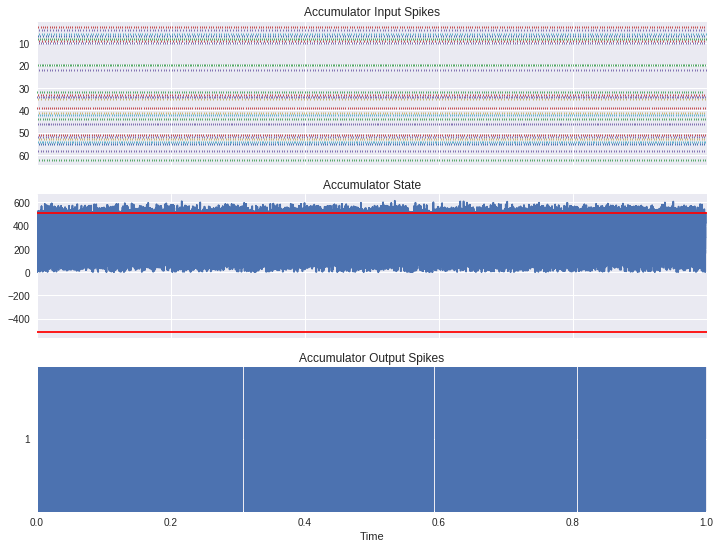

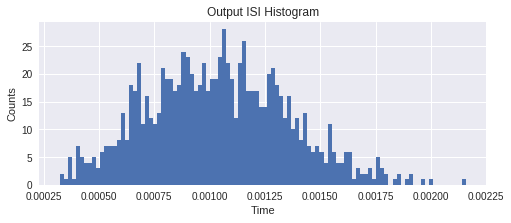

In [6]:
inputs = [-1, -0.5, 0, 0.5, 1]
# inputs = [-1]
for x_in in inputs:
    x, a = tuning_curves(ens, sim, inputs=np.array([x_in]))
    threshold, weights = threshold_weights(sim.data[conn].weights[0])
    spks_in, acc_state, spks_out = run_experiment(
        N=N, input_rates=a, weights=weights, thresheld=threshold, T=1.)
    plot_timeseries(spks_in, acc_state, spks_out, tmax=1.)
    plot_isi(spks_out, bins=100)

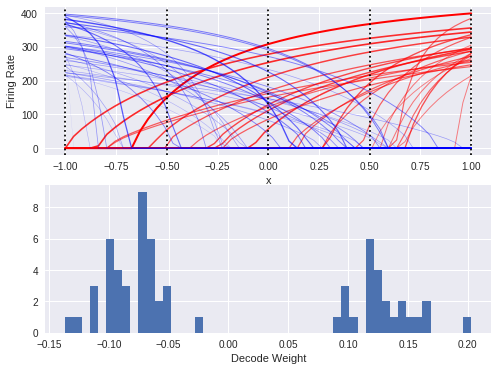

In [34]:
x_test = [-1, -0.5, 0, 0.5, 1]
# print(sim.data[ens].encoders)
fig, axs = plt.subplots(nrows=2, figsize=(8,6))
x, a = tuning_curves(ens, sim)

max_weight = np.max(np.abs(sim.data[conn].weights[0,:]))

for enc, color in zip([1, -1], ['r', 'b']):
    idx = (sim.data[ens].encoders == enc)[:,0]
    lines = axs[0].plot(x, a[:, idx], color)
    line_weights = np.abs(sim.data[conn].weights[0,idx])/max_weight
    for line, line_weight in zip(lines, line_weights):
        line.set_alpha(line_weight)
        line.set_linewidth(line_weight*2)
    
n, bins, patches = axs[1].hist(sim.data[conn].weights[0,:], bins=50)
axs[0].set_xlabel('x')
axs[0].set_ylabel('Firing Rate')
axs[1].set_xlabel('Decode Weight')

for xval in x_test:
    axs[0].axvline(xval, color='k', linestyle=':')

In [8]:
# check the network by running a simulation
sim.run(1)

Simulating finished in 0:00:01.                                                 


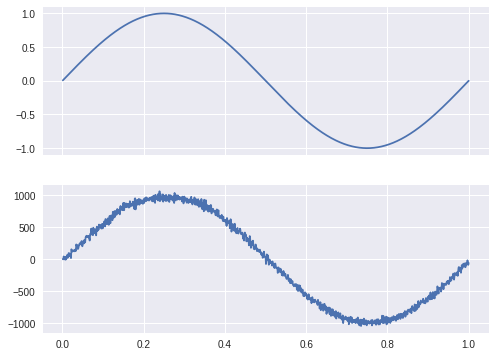

In [9]:
fig, axs = plt.subplots(nrows=2, figsize=(8,6), sharex=True)
# print(sim.data[probe])
# print(sim.trange())
axs[0].plot(sim.trange(), sim.data[probe_in])
axs[1].plot(sim.trange(), sim.data[probe_out])



# Appendix

In [14]:
# check that threshold scaling works
fmax = 500.
for n in [10, 20, 30, 40, 50, 100, 200]:
    input_rates = np.random.uniform(0, 400, size=N)
    weights = np.random.randint(0, 11, size=N)
    threshold = int(np.sum(input_rates*weights)/fmax)
    T=10
    spks_in, acc_state, spks_out = run_experiment(
        N=N, input_rates=input_rates, weights=weights, thresheld=threshold, T=0.5)
    print("avg output spike rate = %f" % (1./np.mean(np.diff(spks_out.times))))

avg output spike rate = 502.067586
avg output spike rate = 501.876828
avg output spike rate = 501.326554
avg output spike rate = 501.870573
avg output spike rate = 502.456931
avg output spike rate = 499.720526
avg output spike rate = 500.451657
